## Knowledge distillation tutorial

This is a Pytorch tutorial for **knowledge distillation**(Hinton et al, 2015).

In [1]:
import torch
import torchvision
from torchvision import datasets
import torch.optim as optim
import torch.nn.functional
import torchvision.transforms as transforms
from torch import nn

import matplotlib.pyplot as plt
import numpy as np

/home/xiaohan/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                        (0.2023, 0.1994, 0.2010)),
])

In [3]:
training_data = datasets.CIFAR10(
    root="~/data",
    train=True,
    download=False,
    transform=transform_train
)
test_data = datasets.CIFAR10(
    root="~/data",
    train=False,
    download=False,
    transform=transform_test
)

In [4]:
# parameters
temperature = 5.
soft_targets_weight = 100.
label_loss_weight = 0.5

max_epoch = 50
batch_size = 256
lr = 1e-3

use_cuda = torch.cuda.is_available()

In [5]:
from random import shuffle


trainloader = torch.utils.data.DataLoader(training_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=8)
testloader = torch.utils.data.DataLoader(test_data,
                                        batch_size=batch_size,
                                        shuffle=False,
                                        num_workers=8)

**Models**:  
The small model(student model): VGG11  
The large model(teacher model): VGG16

In [6]:
StudentModel = torchvision.models.vgg11_bn()
TeacherModel = torchvision.models.vgg16_bn(weights="DEFAULT")

**Loss Functions**:  
KL Divergence loss for soft targets  
Cross entropy loss for true label loss

In [7]:
kl_div_loss = nn.KLDivLoss(log_target=True)
loss_func = nn.CrossEntropyLoss()

In [8]:
optimizer = optim.SGD(StudentModel.parameters(), lr=lr, momentum=0.9,
                      weight_decay=5e-4)

In [9]:
if use_cuda:
    StudentModel.cuda()
    TeacherModel.cuda()

In [10]:
def counter(outputs, labels):
    pre = torch.max(outputs.data.cpu(), 1)[1].numpy()
    y = labels.data.cpu().numpy()
    correct_num = (pre == y).sum()
    return correct_num

function (1):  
$$p_i = \frac{\exp (\frac{v_i}{T})}{\sum_j \exp (\frac{v_j}{T})}$$

function (2):  
$$q_i = \frac{\exp (\frac{z_i}{T})}{\sum_j \exp (\frac{z_j}{T})}$$

In [11]:
summary = {"train_acc": [], "val_acc": []}

In [13]:
for epoch in range(max_epoch):

    # training mode for the student model
    StudentModel.train()
    # evaluation mode for the teacher model
    TeacherModel.eval()

    correct_num = 0
    total_num = 0
    
    for i, (train_batch, labels_batch) in enumerate(trainloader):
        if use_cuda:
            train_batch, labels_batch = train_batch.cuda(), labels_batch.cuda()
        
        # get the outputs from the teacher model
        with torch.no_grad():
            outputs_teacher_batch = TeacherModel(train_batch)
        
        # get the outputs from the student model
        outputs_student_batch = StudentModel(train_batch)

        # soft targets, function (1)
        soft_targets = nn.functional.log_softmax(outputs_teacher_batch / temperature, dim=-1)
        # soft prediction, temperature adjusted probabilities of the small model, function (2)
        soft_prob = nn.functional.log_softmax(outputs_student_batch / temperature, dim=-1)

        # Calculate the soft targets loss
        soft_targets_loss = kl_div_loss(soft_prob, soft_targets)
        # Calculate the true label loss
        label_loss = loss_func(outputs_student_batch, labels_batch)

        # Weighted sum of the two losses
        loss = soft_targets_weight * soft_targets_loss + label_loss_weight * label_loss

        # clear previous gradients, compute gradients of all variables wrt loss
        optimizer.zero_grad()
        loss.backward()

        # performs updates using calculated gradients
        optimizer.step()

        correct_num_batch = counter(outputs_student_batch, labels_batch)
        correct_num += correct_num_batch
        total_num += len(labels_batch)
    
    # traing accuracy and loss
    train_acc = correct_num / total_num * 100.
    summary["train_acc"].append(train_acc)

    # evaluation
    StudentModel.eval()
    correct_num = 0
    total_num = 0
    for i, (val_batch, labels_val_batch) in enumerate(testloader):
        if use_cuda:
            val_batch, labels_val_batch = val_batch.cuda(), labels_val_batch.cuda()
        outputs_val_batch = StudentModel(val_batch)
        correct_num_batch = counter(outputs_val_batch, labels_val_batch)
        correct_num += correct_num_batch
        total_num += len(labels_val_batch)
    val_acc = correct_num / total_num * 100.
    summary["val_acc"].append(val_acc)

    print("Epoch: {}/{}, training acc: {:>6.2f}, val acc: {:>6.2f}".format(epoch+1, max_epoch, train_acc, val_acc))



Epoch: 1/50, training acc:  45.50, val acc:  53.80
Epoch: 2/50, training acc:  53.68, val acc:  57.33
Epoch: 3/50, training acc:  59.75, val acc:  60.87
Epoch: 4/50, training acc:  64.49, val acc:  62.17
Epoch: 5/50, training acc:  68.55, val acc:  63.75
Epoch: 6/50, training acc:  72.54, val acc:  65.05
Epoch: 7/50, training acc:  76.47, val acc:  65.44
Epoch: 8/50, training acc:  80.21, val acc:  66.37
Epoch: 9/50, training acc:  84.07, val acc:  66.99
Epoch: 10/50, training acc:  87.55, val acc:  66.94
Epoch: 11/50, training acc:  90.56, val acc:  66.16
Epoch: 12/50, training acc:  93.24, val acc:  67.17
Epoch: 13/50, training acc:  95.68, val acc:  66.69
Epoch: 14/50, training acc:  97.29, val acc:  67.07
Epoch: 15/50, training acc:  98.33, val acc:  67.48
Epoch: 16/50, training acc:  98.83, val acc:  67.46
Epoch: 17/50, training acc:  99.38, val acc:  66.99
Epoch: 18/50, training acc:  99.59, val acc:  67.78
Epoch: 19/50, training acc:  99.76, val acc:  67.58
Epoch: 20/50, trainin

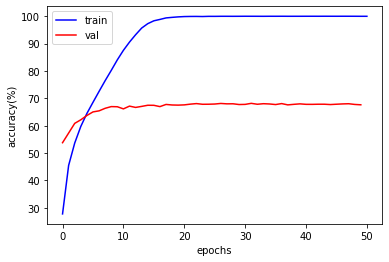

In [14]:
plt.plot(summary["train_acc"], color='b', label = "train")
plt.plot(summary["val_acc"], color='r', label = "val")
plt.xlabel("epochs")
plt.ylabel("accuracy(%)")
plt.legend()
plt.show()

Reference:  
[1] https://pytorch.org/tutorials/beginner/basics/data_tutorial.html  
[2] https://nn.labml.ai/distillation/index.html  
[3] https://github.com/peterliht/knowledge-distillation-pytorch.git